# Classical Optical Flow Estimation: 
## Lucas-Kanade Optical Flow (IJCAI 1981)

## Tutorial Objectives
1. Lucas-Kanade optical flow 알고리즘의 이론적 배경을 이해
2. 기본 Lucas-Kanade 알고리즘을 직접 구현
3. Iterative Lucas-Kanade 알고리즘을 구현하고 성능을 비교
4. KITTI 데이터셋을 사용하여 알고리즘을 평가
5. OpenCV의 구현과 자체 구현의 결과를 비교분석

---

<img src="https://drive.google.com/uc?id=1IwXipsiw_wO5L7b247O9pdD3CMeOx0_9" height = 150 width=390>

**Citation**
```
@inproceedings{lucas1981iterative,
  title={An iterative image registration technique with an application to stereo vision},
  author={Lucas, Bruce D and Kanade, Takeo},
  booktitle={IJCAI'81: 7th international joint conference on Artificial intelligence},
  volume={2},
  pages={674--679},
  year={1981}
}
```
---

## 1. Environment Setup

필요한 라이브러리를 설치하고 불러옵니다.

In [ ]:
from typing import *
import numpy as np
from scipy import signal
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import math

## 2. KITTI Dataset Download

KITTI Flow 2015 데이터셋을 다운로드합니다. 이 데이터셋은 실제 driving scenario에서 촬영된 200개의 이미지 쌍으로 구성되어 있습니다.

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
!unzip data_scene_flow.zip -d ./Kitti/

## 3. Basic Concepts of Optical Flow

### 3.1 What is Optical Flow?
Optical flow는 연속된 두 프레임 사이에서 픽셀의 움직임을 나타내는 2D vector field입니다. 각 픽셀이 시간에 따라 어떻게 이동했는지를 추정합니다.

### 3.2 Basic Assumptions
1. **Brightness Constancy**: 움직이는 픽셀의 밝기는 시간에 따라 변하지 않습니다.
   - $I(x, y, t) = I(x + u, y + v, t + 1)$
   
2. **Spatial Coherence**: 인접한 픽셀들은 유사한 움직임을 갖습니다.

### 3.3 Lucas-Kanade Method
Lucas-Kanade 방법은 local window 내에서 optical flow가 일정하다고 가정합니다. 

## 4. Helper Function Definitions

### 4.1 Optical Flow Visualization Function
계산된 optical flow를 화살표로 시각화하는 함수입니다.

In [ ]:
def flow_to_arrow(img: np.ndarray, flow: np.ndarray, scale=20, color=(255, 0, 0), step=25):
    """
    Visualize optical flow as arrows

    Args:
        img: Original image
        flow: Optical flow in the shape of (2, H, W)
        scale: Scaling factor for arrow size
        color: Arrow color
        step: Spacing between arrows

    Returns:
        Image with arrows drawn
    """
    _, h, w = flow.shape
    img_with_flow = img.copy()
    for y in range(0, h, step):
        for x in range(0,w,step):
            dx, dy = flow[:, y, x]
            if abs(dx) > 0. or abs(dy) > 0.:
                cv2.arrowedLine(
                    img_with_flow, (x,y), (int(x + dx*scale), int(y + dy*scale)), color, 2)

    return img_with_flow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 5. Lucas-Kanade Algorithm Implementation

### 5.1 Theoretical Background

Lucas-Kanade 알고리즘은 다음 단계로 구성됩니다:
1. 이미지 그래디언트 계산 ($I_x, I_y, I_t$)
2. 각 픽셀에 대해 윈도우 내의 연립방정식 구성
3. Least Square Method으로 optical flow $(u, v)$ 계산

수식:
$$I_x u + I_y v + I_t = 0$$

이를 윈도우 내의 모든 픽셀에 대해 적용하면:
$$\mathbf{A}\mathbf{d} = \mathbf{b}$$

여기서 $\mathbf{A} = \begin{bmatrix} I_x \\ I_y \end{bmatrix}$, $\mathbf{d} = \begin{bmatrix} u \\ v \end{bmatrix}$, $\mathbf{b} = -I_t$

<img src="https://drive.google.com/uc?id=1SAzDo6bzjWFdwfTF0VV7UyCqmZysFtb1" height = 300 width=600>

#### Good features

<img src="https://drive.google.com/uc?id=1M9ITDLhJ3wJ2PebZCbKriRWuSpzOrHIx" height = 25 width=550>

##### 1. 핵심 개념

##### Determinant (det)
- $$\text{det} = \det(A^\top A)$$
- 이미지 패치의 feature point 강도를 나타냄
- 값이 클수록 해당 영역이 코너일 가능성이 높음
- $$\lambda_1, \lambda_2$$
  - $$\lambda_1 \approx 0, \lambda_2 \approx 0$$ 
    - → Flat region (평탄 영역, det 작음)
  - $$\lambda_1 \approx 0, \lambda_2 \gg 0$$ 
    - → Edge (한 방향 변화만 큼, det 작음)
  - $$\lambda_1 \gg 0, \lambda_2 \gg 0$$ 
    - → Corner (두 방향 모두 큰 변화, det 큼)

##### Trace (trace)
- $$\text{trace} = \text{Trace}(A^\top A)$$
- 행렬의 대각합(고유값의 합) → 평균 변화(gradient 강도)를 나타냄
- $$\text{trace}^2$$
  - 평균 움직임 크기의 제곱
- 값이 클수록 에지(경계)에 가까운 영역일 가능성 높음

##### 2. Good Feature 조건

**조건:**
- det 크고, trace 작을수록 좋은 특징점

**Harris Response Function:**
$$R = \det(M) - \alpha \cdot \text{trace}(M)^2$$

- $\alpha$: 경험적 상수 (보통 0.04 ~ 0.06)

**Good Feature 판단:**
$$R > \tau$$
($\tau$: 임계값)

In [ ]:
def optical_flow(I1g: np.ndarray, I2g: np.ndarray, window_size: int, tau:float =0.1, alpha:float = 0.1) \
    -> Tuple[np.ndarray, np.ndarray]:
    """
    Lucas-Kanade optical flow algorithm

    Args:
        I1g: First image (grayscale)
        I2g: Second image (grayscale)
        window_size: Window size
        tau: Threshold value (for selecting good feature points)
        alpha: Parameter for Harris corner response calculation

    Returns:
        Optical flow in the shape of (2, H, W)
    """

    # x, y, t 방향 미분을 위한 커널 정의
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])

    w = window_size//2
    
    # 입력 이미지를 0~1 사이로 normalize
    I1g = I1g / 255.
    I2g = I2g / 255.

    # 컨볼루션 연산 결과가 입력 이미지와 같은 크기가 되도록 설정
    mode = 'same' 
    
    # x방향 미분값 계산 (첫 번째 이미지)
    fx = signal.convolve2d(I1g, kernel_x, mode=mode)

    # y방향 미분값 계산 (첫 번째 이미지)
    fy = signal.convolve2d(I1g, kernel_y, mode=mode)

    # t방향 미분값 계산 (두 번째 이미지와 첫 번째 이미지의 차이)
    ft = signal.convolve2d(I2g, kernel_t, mode=mode) \
         + signal.convolve2d(I1g, -kernel_t, mode=mode)
    
    # Optical flow 결과를 저장할 배열 초기화 (u: x방향, v: y방향)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    # 모든 픽셀에 대해 윈도우를 중심으로 Optical flow 계산
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            ## fx, fy, ft에서 윈도우 내의 미분값을 1차원 배열로 추출
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            #### TODO 1: matrix A, vector b 생성하기 (2 lines)####
            # - b는 It (윈도우 내 시간 미분값)
            # - A는 Ix, Iy를 각각 하나의 열로 쌓아 2D 행렬로 만듦 (각 row는 [Ix, Iy])


            #### TODO 2: ATA와 trace, det 계산하기 (3 lines)####
            # - ATA =
            # - trace는 ATA의 대각선 원소들의 합
            # - det는 ATA의 행렬식


            #### TODO 3: Harris corner 응답(R) 계산 및 좋은 특징점(코너) 아닌 경우 skip (3 lines) ####
            # R = det - alpha * trace^2
            # R이 tau보다 작거나 같으면(즉, 코너가 아니면) optical flow 계산하지 않음


            #### TODO 4: Least Squares로 d (u, v) 계산 (1 line) ####

            
            u[i,j]=d[0]
            v[i,j]=d[1]

    return np.concatenate([u[None, ...],v[None, ...]], axis=0)

## 6. Experiment Configuration

실험에 사용할 파라미터들을 설정합니다.

In [ ]:
# configurate
start_idx, end_idx = 13, 17
window_size = 5 # try different window sizes.
tau = window_size*math.sqrt(2)*10 
img1_filefmt: str = "/content/Kitti/training/image_2/%06d_10.png"
img2_filefmt: str = "/content/Kitti/training/image_2/%06d_11.png"
gt_filefmt: str = "/content/Kitti/training/flow_occ/%06d_10.png"

## 7. KITTI Dataset Introduction

<img src="https://drive.google.com/uc?id=1kPICEzjM8gmYOxU4wDv2qlKDQFtMEEsq" height = 150 width=430>
<img src="https://drive.google.com/uc?id=1pGLDKXWy4xtEAmEQouivjqrPo0QTplhs" height = 150 width=430>

### 7.1 Dataset Characteristics
- **KITTI Flow 2015**: Real dynamic scenes of 200 image pairs in a driving scenario
- 동적 장면과 정적 장면이 모두 포함
- Ground truth optical flow가 LiDAR 데이터로부터 생성됨

### 7.2 Data Format
- 입력: 연속된 두 프레임 (RGB 이미지)
- Ground Truth: 16-bit PNG 형식의 optical flow
- 평가: End-Point Error (EPE) 사용

Dataset website: https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=flow

In [ ]:
# load images
img1, img2 = [], []
img1_vis, img2_vis = [], []
gts, valids = [], []
for fidx in range(start_idx, end_idx+1):
    im1 = np.asarray(Image.open(img1_filefmt % fidx))
    im2 =  np.asarray(Image.open(img2_filefmt % fidx))
    img1_vis.append(im1)
    img2_vis.append(im2)

    im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
    img1.append(im1)
    img2.append(im2)

    gt = cv2.imread(gt_filefmt % fidx, cv2.IMREAD_ANYDEPTH|cv2.IMREAD_COLOR)
    gt = gt[...,::-1].astype(np.float32)
    gt, valid = gt[...,:2], gt[...,2]
    gt = (gt - 2**15) / 64.0
    gts.append(gt.transpose(2,0,1))
    valids.append(valid)

assert len(img1) == len(img2)

## 8. Basic Lucas-Kanade Algorithm Execution

구현된 Lucas-Kanade 알고리즘을 KITTI 데이터셋에 적용합니다.

In [ ]:
# run the Lucas-Kanade algorithm
results = []
flow_imgs = []
i=0
while i < len(img1):
    print(f"Start {i}")
    pred_flow = optical_flow(img1[i], img2[i], window_size=window_size, tau=tau)
    print(f"Finished {i}")
    results.append(pred_flow)

    flow_img = flow_to_arrow(img1_vis[i], pred_flow)
    flow_imgs.append(flow_img)

    flow_img = flow_to_arrow(img2_vis[i], pred_flow)
    flow_imgs.append(flow_img)

    i += 1

## 9. Iterative Lucas-Kanade Algorithm

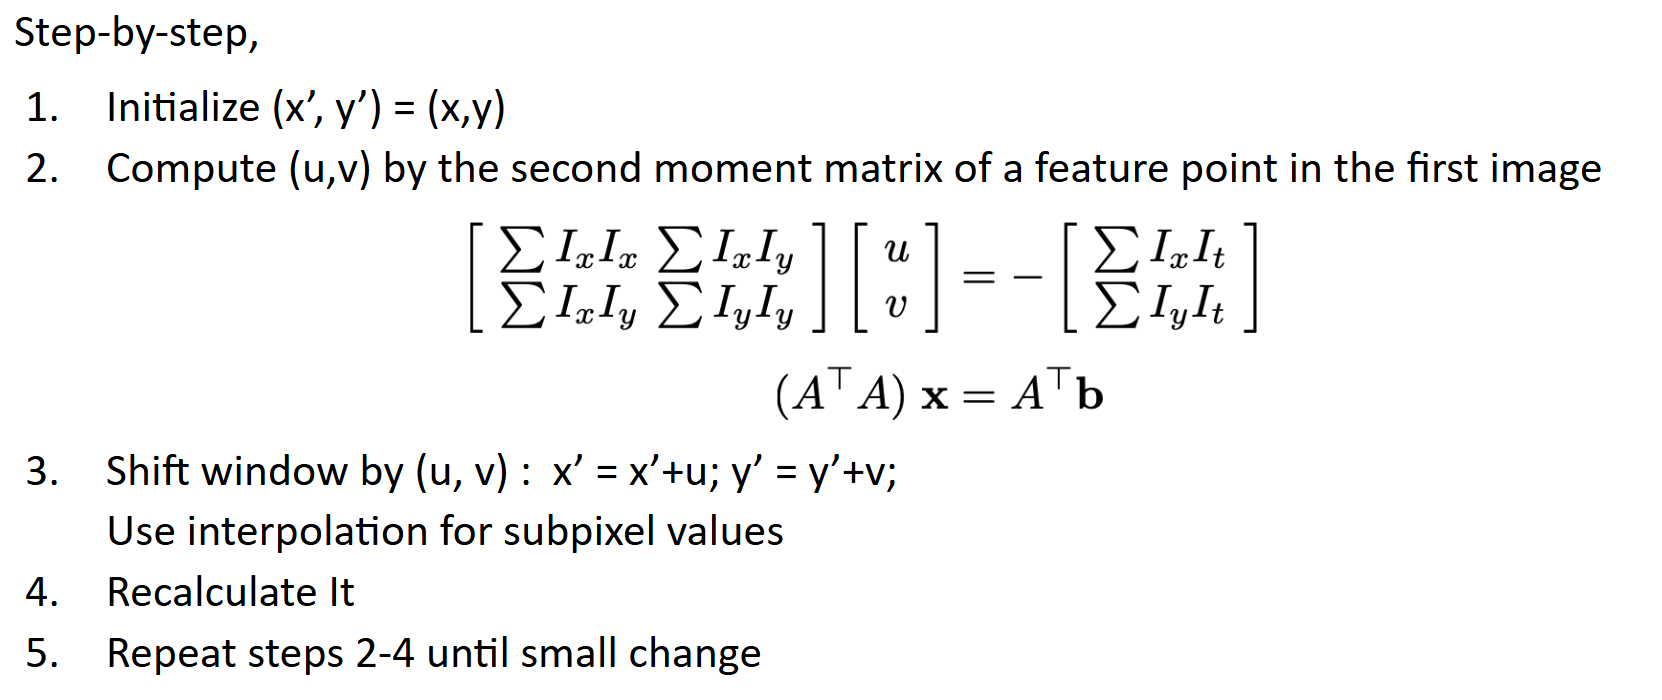

### 9.1 Need for Improved Algorithm
기본 Lucas-Kanade 알고리즘은 작은 움직임에 대해서만 정확합니다. 큰 움직임을 처리하기 위해 반복적(iterative) 접근법을 사용해야합니다.

### 9.2 Algorithm Process
1. 초기 optical flow를 0으로 설정
2. 현재 optical flow에 따라 두 번째 이미지를 warp
3. 워핑된 이미지와 첫 번째 이미지 사이의 optical flow 계산
4. 전체 optical flow 업데이트
5. 수렴할 때까지 2-4 단계 반복

In [ ]:
from scipy.ndimage import map_coordinates

def warp_image(I, u, v):
    """주어진 optical flow (u, v)를 이용해 이미지를 워핑(warping)하는 함수"""
    rows, cols = I.shape  
    
    # 각 픽셀의 (y, x) 좌표 생성 (coords_y: 세로 좌표, coords_x: 가로 좌표)
    # np.mgrid[0:rows, 0:cols]는 각 픽셀 위치를 (행, 열) 형태로 만듦
    # optical flow (v, u)를 더해서, 픽셀이 어디로 이동해야 하는지 새로운 좌표 계산
    coords_y, coords_x = np.mgrid[0:rows, 0:cols] + [v, u]

    # 계산된 맵 좌표([coords_y, coords_x])를 사용해, 원본 이미지를 워핑 (보간은 bilinear(order=1), 경계는 reflect)
    warped_I = map_coordinates(I, [coords_y, coords_x], order=1, mode='reflect')

    return warped_I

def iterative_optical_flow(I1g: np.ndarray, I2g: np.ndarray, window_size: int, num_iterations: int = 3, tau:float =0.1, alpha:float = 0.1) \
    -> Tuple[np.ndarray, np.ndarray]:
    """
    Iterative Lucas-Kanade optical flow algorithm

    Args:
        I1g: First image (grayscale)
        I2g: Second image (grayscale)
        window_size: Window size
        num_iterations: Number of iterations
        tau: Threshold value
        alpha: Parameter for Harris corner response

    Returns:
        Optical flow in the shape of (2, H, W)
    """

    # optical flow (u, v) 결과 저장용 배열을 0으로 초기화 (시작값)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    # 반복적으로 optical flow를 refine(보정)하기 위한 루프
    for _ in range(num_iterations):
        ##### TODO Iterative Lucas-Kanade 알고리즘 구현 (3 steps) #####
        # 1. 두 번째 이미지를 현재 optical flow (u, v)만큼 warp_image로 보정
        # 2. optical_flow 함수로 현재 흐름에 대한 변화량(du, dv) 계산 (I1g, 보정된 I2g_warped 입력)
        # 3. 누적 optical flow (u, v)에 변화량 (du, dv) 더해서 갱신


    # (2, H, W) 형태로 반환 (u: 0번째 채널, v: 1번째 채널)
    return np.concatenate([u[None, ...], v[None, ...]], axis=0)

## 10. Iterative Lucas-Kanade Algorithm Execution

개선된 알고리즘을 동일한 데이터셋에 적용하여 성능을 비교합니다.

In [ ]:
# run the Iterative Lucas-Kanade algorithm
iter_results = []
iter_flow_imgs = []
i=0
while i < len(img1):
    print(f"Start {i}")
    pred_flow = iterative_optical_flow(img1[i], img2[i], window_size=window_size, tau=tau)
    print(f"Finished {i}")
    iter_results.append(pred_flow)

    flow_img = flow_to_arrow(img1_vis[i], pred_flow)
    iter_flow_imgs.append(flow_img)

    flow_img = flow_to_arrow(img2_vis[i], pred_flow)
    iter_flow_imgs.append(flow_img)

    i += 1

## 11. Performance Evaluation

### 11.1 End-Point Error (EPE)
EPE는 예측된 optical flow와 ground truth 사이의 Euclidean Distance입니다:

$$EPE = \sqrt{(u_{pred} - u_{gt})^2 + (v_{pred} - v_{gt})^2}$$

End point Error
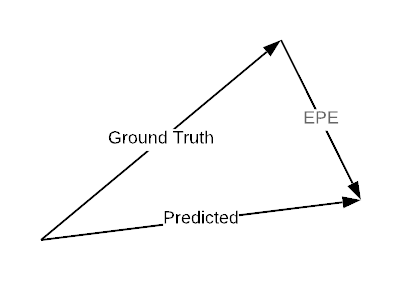


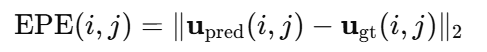


### 11.2 Evaluation Results

In [ ]:
result_flows = np.stack(results)
iter_result_flows = np.stack(iter_results)

ground_truths = np.stack(gts)
valid_masks = np.stack(valids)
valid_masks = valid_masks >= 0.5  # 유효한 optical flow 마스크 (float→bool 변환)

###### TODO End-point-error(EPE) 정의 및 수식을 확인하고, 아래와 같이 구현하세요 (2 lines) ######
# EPE란, 예측한 optical flow와 GT flow의 유클리드 거리를 의미
# 각 flow의 (u, v) 차이를 제곱합한 뒤 sqrt로 픽셀별 error를 계산합니다.


# 유효한 픽셀만 선택하여 평가 (valid mask가 True인 위치만)
epe = epe[valid_masks]
epe_iter = epe_iter[valid_masks]

# EPE 평균과 이미지 크기 출력
print(f"End point error: {np.mean(epe):.2f}, Image size: {results[0].shape[1]} x {results[0].shape[2]}")
print(f"End point error with iterative version: {np.mean(epe_iter):.2f}, Image size: {iter_results[0].shape[1]} x {iter_results[0].shape[2]}")

## 12. Result Analysis and Visualization

### 12.1 Result Saving and GIF Generation
계산된 optical flow를 시각적으로 확인하기 위해 GIF로 저장합니다.

In [ ]:
import imageio

imageio.mimwrite('drive/MyDrive/output.gif', flow_imgs)
for i, img in enumerate(flow_imgs):
    img =Image.fromarray(img)
    img.save(f"drive/MyDrive/output_{i//2}_{i%2}.png")

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

In [ ]:
gifPath = Path("/content/drive/MyDrive/output.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

## 13. Comparison with OpenCV Implementation

### 13.1 OpenCV Lucas-Kanade Implementation
OpenCV에서 제공하는 Lucas-Kanade 구현과 성능을 비교

### 13.2 Feature-based Approach
OpenCV는 좋은 특징점(good features to track)을 먼저 찾고, 이들 점에서만 optical flow를 계산합니다.

In [ ]:
## cv2로 구현된 LK 알고리즘 실행 방법 ##

i = 0
cv2_flow_imgs = []
while i < len(img1):
    print(f"Start {i}")

    # cv2의 코너 검출 함수: 좋은 특징점(코너) 추출 (max 1000개, 품질 0.3, 최소거리 7, blockSize 7)
    pt0 = cv2.goodFeaturesToTrack(img1[i], maxCorners=1000, qualityLevel=0.3, minDistance=7, blockSize=7)
    # calcOpticalFlowPyrLK로 optical flow 추정 (pt0: 이전 특징점 → pt1: 다음 이미지에서 찾은 점)
    pt1, st, err = cv2.calcOpticalFlowPyrLK(img1[i], img2[i], pt0, None)

    # optical flow가 정상적으로 추적된 점만 선택
    good_prev = pt0[st == 1]
    good_next = pt1[st == 1]

    # flow 결과 저장용 배열 초기화 (2, H, W)
    flow = np.zeros((2, img1[0].shape[0], img1[0].shape[1]))

    # 특징점 별로 optical flow 계산 및 시각화
    for j, (new, old) in enumerate(zip(good_next, good_prev)):
        a, b = new.ravel()   # new: 다음 프레임 특징점 좌표
        c, d = old.ravel()   # old: 이전 프레임 특징점 좌표

        #### TODO new 특징점과 old 특징점을 사용하여 optical flow 성분 u, v를 계산하세요 (1 lines) ####
        # u: x 방향 이동량, v: y 방향 이동량

        c, d = int(c), int(d)   # 좌표를 정수형으로 변환 (이미지 인덱싱 위해)

        # flow 배열 해당 위치에 optical flow (u, v) 할당
        flow[0, d, c] = u
        flow[1, d, c] = v

    # optical flow를 화살표로 시각화 (첫 번째/두 번째 이미지 기준)
    vis = flow_to_arrow(img1_vis[i], flow, step=1, scale=1)
    vis2 = flow_to_arrow(img2_vis[i], flow, step=1, scale=1)

    # 결과 이미지 저장용 리스트에 추가
    cv2_flow_imgs.append(vis)

    # 이미지 저장 (PIL로 변환 후 파일로 저장)
    vis, vis2 = Image.fromarray(vis), Image.fromarray(vis2)
    vis.save(f'drive/MyDrive/opencv_{i}_0.png')
    vis2.save(f'drive/MyDrive/opencv_{i}_1.png')
    i += 1

# gif로 결과 시각화
imageio.mimwrite('drive/MyDrive/cv2_output.gif', cv2_flow_imgs)

In [ ]:
gifPath = Path("/content/drive/MyDrive/cv2_output.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

## 14. Tutorial Summary and Conclusions

### 14.1 Learning Summary
1. **Lucas-Kanade Algorithm Theoretical Background**
   - Brightness constancy와 spatial coherence 가정
   - Least Squares Method을 통한 optical flow 계산

2. **Implementation and Experiments**
   - 기본 Lucas-Kanade 알고리즘 구현
   - Iterative 버전을 통한 성능 개선
   - KITTI 데이터셋을 사용한 정량적 평가

3. **Performance Analysis**
   - End-Point Error를 통한 정량적 평가
   - OpenCV 구현과의 비교

### 14.2 Algorithm Limitations
1. **Assumption Limitations**: Brightness constancy가 항상 성립하지 않음
2. **Computational Complexity**: dense optical flow 계산의 높은 계산 비용
3. **Large Motion**: 기본 알고리즘은 작은 움직임에만 적합

### 14.3 Improvement Directions
1. **Pyramid Method**: 다중 해상도를 이용한 큰 움직임 처리
2. **Deep Learning Approaches**: CNN 기반의 optical flow 추정